In [4]:
import geopandas as gpd
import fiona
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

After viewing the raw data in QGIS to familiarize myself, I'm going to go ahead and load the two shapefiles into a local PostGIS database.

The first step is to clean up the parcel layer. I need to dissolve by property owner and I am only interested in parcels with farm acres > 0. 

I can do both of these steps easily in with a PostGIS query.


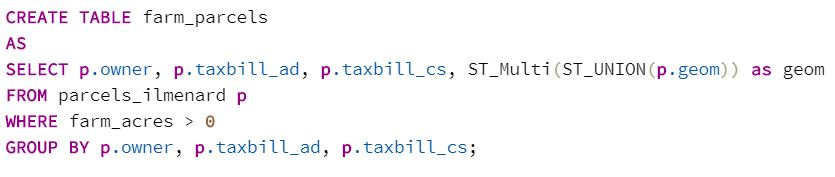

## Now to work on the silo layer...

The diameter of the shapefile silos do not precicesly match those in the reference PDF.
I'll need to convert the PDF into a csv so I can use it as a Pandas dataframe and find the closest match with the reference.

After some trial and error with the 'tabula-python' package (a pdf-csv) converter, I have decided to use the GUI due to issues with spacing and just get on with it!

Because I am estimating capacity, and with identical diameter measurements, I've made a call to use only the "wide corrugated bins" as my reference for volume estimation.

### Let's take a look at the columns available.

In [5]:
df = pd.read_csv("silo_capacity.csv")
silos = gpd.read_file('silos_ilmenard.shp')
print(silos.columns)
print(df.columns)

Index(['DIAMETER', 'geometry'], dtype='object')
Index(['Diameter', 'Tiers', 'Bin-Model', 'Bushels', 'US_tons_Corn',
       'Metric_tons_Corn', 'US_Tons_Wheat', 'Metric_Tons_Wheat', 'Low-Floor',
       'High-Floor', 'eaveheightfeetInches', 'Eave_Height_m',
       'fillheightInches', 'Fill-Height_m'],
      dtype='object')


### I'm going to get a list of known silo diameters and match the shapefile estimates to the nearest value.
#### If height data were also available height data, I could do the same here.

In [6]:
#height_range = list(df2.Eave_Height_m.unique())
#print(height_range)

#First I'll get a range diameter values
diameter_range = list(df.Diameter.unique())
print(diameter_range)

[4.6, 5.5, 6.4, 7.3, 8.2, 9.1, 10.1, 11.0, 12.8, 14.6]


### Now I need to match the shapfile diameters to the closest reference diameter.

#### I'll create a function to do this and add a resulting column to the silo geodataframe.

In [7]:
# def closest_height(number):
#    return min(height_range, key=lambda x:abs(x-number))
# silos['closest_hi'] = silos['HEIGHT'].apply(closest_height)

def closest_diameter(number):
    return min(diameter_range, key=lambda x:abs(x-number))

silos['closest_di'] = silos['DIAMETER'].apply(closest_diameter)


### Looks pretty good so far

In [8]:
silos.head(10)

,DIAMETER,geometry,closest_di
0,5.970181,"POLYGON ((-89.761038140355 40.11017998598363, ...",6.4
1,5.782834,"POLYGON ((-89.7610309374848 40.110121105254, -...",5.5
2,4.725118,"POLYGON ((-89.76101939039121 40.1101153080984,...",4.6
3,10.958176,"POLYGON ((-89.7645452732458 40.11338562571487,...",11.0
4,8.454480,"POLYGON ((-89.7647079257188 40.11342932677454,...",8.2
5,8.168737,POLYGON ((-89.76480710162004 40.11343606984441...,8.2
6,8.273727,POLYGON ((-89.76492196367224 40.11343940063824...,8.2
7,8.475806,"POLYGON ((-89.7650326274786 40.1134367567451, ...",8.2
8,8.219675,POLYGON ((-89.76513550970466 40.11343733610629...,8.2
9,5.405831,"POLYGON ((-89.76474632362725 40.1132704627026,...",5.5


### While I'm at it, I'll get the corresponding min and max Bushels to provide a ranged estimate of volume.

### I'll also grab the median Bushel value to use as a choropleth in the final visualization.

In [9]:
bushel_dict_min = df.groupby('Diameter')['Bushels'].min().to_dict()
bushel_dict_max = df.groupby('Diameter')['Bushels'].max().to_dict()
bushel_dict = df.groupby('Diameter')['Bushels'].median().to_dict()
print(bushel_dict)

{4.6: 3202.0, 5.5: 5062.0, 6.4: 6970.0, 7.3: 9206.0, 8.2: 12664.5, 9.1: 16886.0, 10.1: 20625.0, 11.0: 24774.0, 12.8: 34343.0, 14.6: 45668.0}


### Add the appropriate columns into the silos geodataframe and map the dictionary appropriately.

### Let's take a look.

In [10]:
silos['low_bushels'] = silos['closest_di'].map(bushel_dict_min)
silos['high_bushels'] = silos['closest_di'].map(bushel_dict_max)
silos['median_bushels'] = silos['closest_di'].map(bushel_dict)

silos.head(10)

,DIAMETER,geometry,closest_di,low_bushels,high_bushels,median_bushels
0,5.970181,"POLYGON ((-89.761038140355 40.11017998598363, ...",6.4,3765,10174,6970.0
1,5.782834,"POLYGON ((-89.7610309374848 40.110121105254, -...",5.5,2709,7416,5062.0
2,4.725118,"POLYGON ((-89.76101939039121 40.1101153080984,...",4.6,1841,4563,3202.0
3,10.958176,"POLYGON ((-89.7645452732458 40.11338562571487,...",11.0,15349,34199,24774.0
4,8.454480,"POLYGON ((-89.7647079257188 40.11342932677454,...",8.2,6482,18847,12664.5
5,8.168737,POLYGON ((-89.76480710162004 40.11343606984441...,8.2,6482,18847,12664.5
6,8.273727,POLYGON ((-89.76492196367224 40.11343940063824...,8.2,6482,18847,12664.5
7,8.475806,"POLYGON ((-89.7650326274786 40.1134367567451, ...",8.2,6482,18847,12664.5
8,8.219675,POLYGON ((-89.76513550970466 40.11343733610629...,8.2,6482,18847,12664.5
9,5.405831,"POLYGON ((-89.76474632362725 40.1132704627026,...",5.5,2709,7416,5062.0


In [11]:
silos.to_file("silo_bushels.shp", driver='ESRI Shapefile')

C:\ProgramData\Miniconda2\envs\gis\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


### Take the shapefile to PostGIS to do the spatial join and math all in one command.
### Recall the dissolved and filtered parcel layer from the beginning. 
### That will now be spatially associated with the silo values!

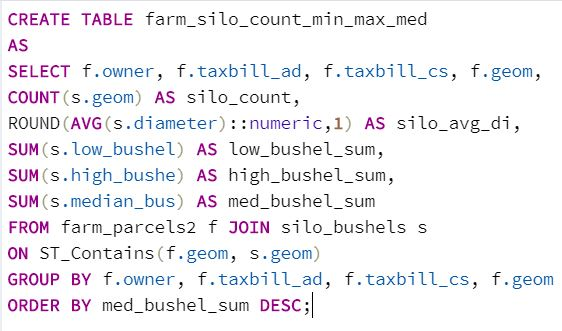

### I find some things to be much more simple in PostGIS ^

### Now bring it back for a quick visualization before exporting to the web

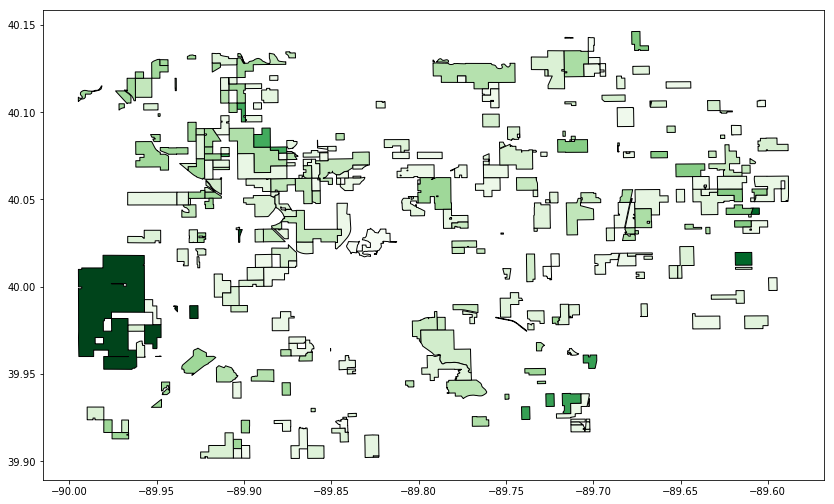

In [12]:
import psycopg2

con = psycopg2.connect('host=localhost dbname=sdb_vinegap user=postgres password=secret')

sql = "SELECT * FROM farm_silo_count_min_max_med;"

parcels = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')

# I'm going to plot by silo count to see if the final map looks similiar
parcels.plot(figsize=(14,18), column='med_bushel_sum', cmap='Greens', edgecolor='Black')

## Let's see who tops the list

In [13]:
# Sort based on the estimated total median bushels
parcels.sort_values('med_bushel_sum', ascending=False).reset_index().head(10)

,index,owner,taxbill_ad,taxbill_cs,geom,silo_count,silo_avg_di,low_bushel_sum,high_bushel_sum,med_bushel_sum
0,4,GRIGSBY FAMILY PARTNERSHIP,10736 MARKERT AV,TALLULA IL 62688,(POLYGON ((-89.98987808275918 39.9599203194489...,9,12.0,178484.0,391235.0,284861.0
1,2,POWELL CHESTER L,16986 PEORIA ST,ATHENS IL 626130000,(POLYGON ((-89.61854156057514 40.0122271605793...,9,11.6,158739.0,350659.0,254700.0
2,5,CARTER LESTER B & IRMA CORRINE,24945 ETHELL AV,ATHENS IL 626130000,(POLYGON ((-89.73623016650971 39.9238850248117...,9,10.1,117091.0,268210.0,192651.5
3,3,WINKELMANN WAYNE A,14944 WHITES CROSSING AV,PETERSBURG IL 62675,(POLYGON ((-89.90853235843124 40.0744678977034...,9,9.8,109466.0,249780.0,179624.0
4,22,SWAAR ROBERT M & SARAH J TRUSTEES,25903 LEVEE ST,GREENVIEW IL 626420000,(POLYGON ((-89.6754552448308 40.13523232232577...,6,9.6,83916.0,186548.0,135232.0
5,78,TODD JAMES H TRUSTEE,29953 SWEETWATER AVE,GREENVIEW IL 62642,(POLYGON ((-89.61428490277886 40.0340663643501...,4,12.1,82273.0,180206.0,131240.0
6,6,WEIDHUNER HOMER & ANNA S,20492 PEORIA ST,GREENVIEW IL 626420000,(POLYGON ((-89.60043153361116 40.0558845435087...,8,8.7,70488.0,170860.0,120676.0
7,27,DIGIOVANNA STEPHEN J,13441 POST ST,ATHENS IL 626139286,(POLYGON ((-89.7482328524159 39.93555175283421...,6,9.4,68926.0,157144.0,113036.0
8,0,PAYDON WILLIAM DEAN & CLARA M,26466 W 135TH ST,PLAINFIELD IL 60544,(POLYGON ((-89.79057023432674 40.0441750931560...,11,7.4,63946.0,162005.0,112976.5
9,25,SMITH STEVEN A,502 N ELM ST,TALLULA IL 626880000,(POLYGON ((-89.90144242176815 39.9071429648097...,6,9.6,69423.0,156458.0,112943.0


### Looks like the Grigsby family of Tallula, Illinois is a top priority!
### A quick satellite view of their land shows even more silos exist than were originally captured!
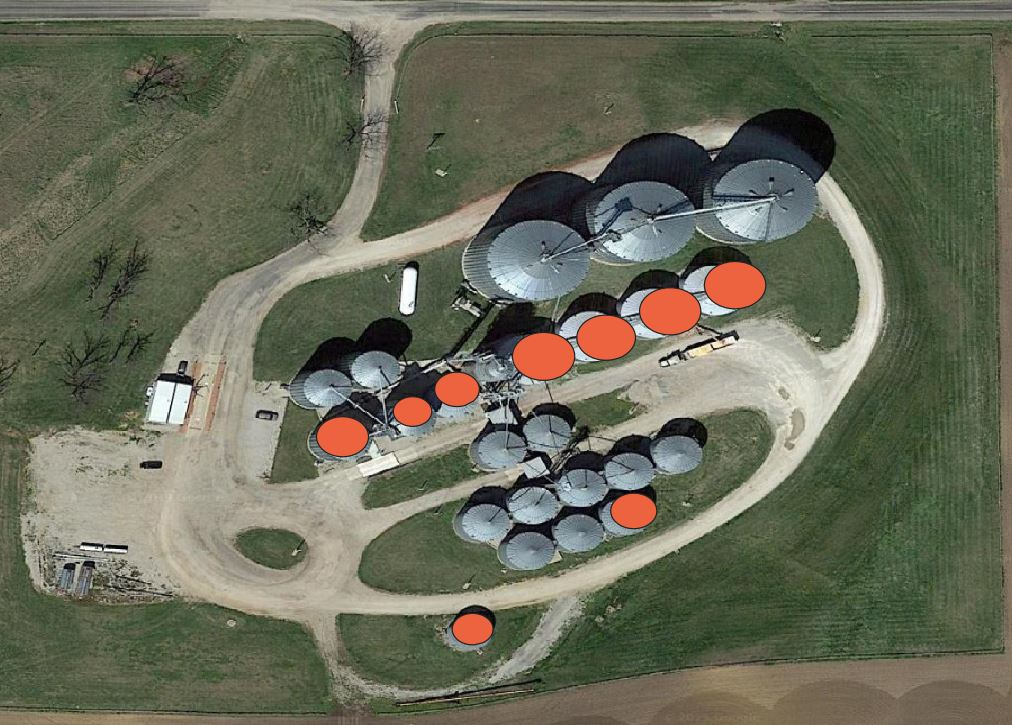

## Save the file to geoJSON and a trusty Shapefile

In [16]:
parcels.to_file("menard_il_indigo_leads.geojson", driver='GeoJSON')
parcels.to_file("menard_il_indigo_leads.shp", driver='ESRI Shapefile')